In [1]:
# script for exploring the credit card fraud detection dataset using pandas, matplotlib, and seaborn.
# The script will cover loading the data, performing exploratory data analysis (EDA), and building a RandomForestClassifier model

# data: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/code

# The Data contains Anonymised credit card transactions labeled as fraudulent or genuine
# Feature 'Class' takes value 1 in case of fraud and 0 otherwise.
# We can use these historical classifications to predict cases of fraud in future.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
# Load dataset from local storage
df = pd.read_csv('creditcard.csv')

# Display first few rows
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Display shape of the dataset
df.shape

(284807, 31)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
df.isnull().sum().sum()

0

In [27]:
df.duplicated().sum()

1081

0    284315
1       492
Name: Class, dtype: int64


([<matplotlib.axis.XTick at 0x1aed3cf2d90>,
 [Text(0, 0, 'Not Fraud'), Text(1, 0, 'Fraud')])

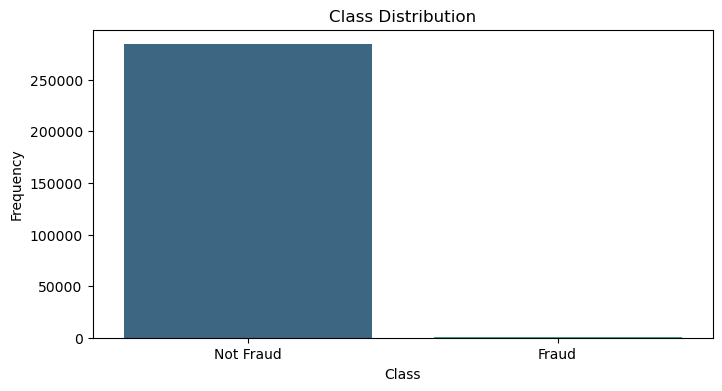

In [14]:
# Check class distribution
class_counts = df['Class'].value_counts()
print(class_counts)

# Plot class distribution
plt.figure(figsize=(8,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])

Text(0, 0.5, 'Density')

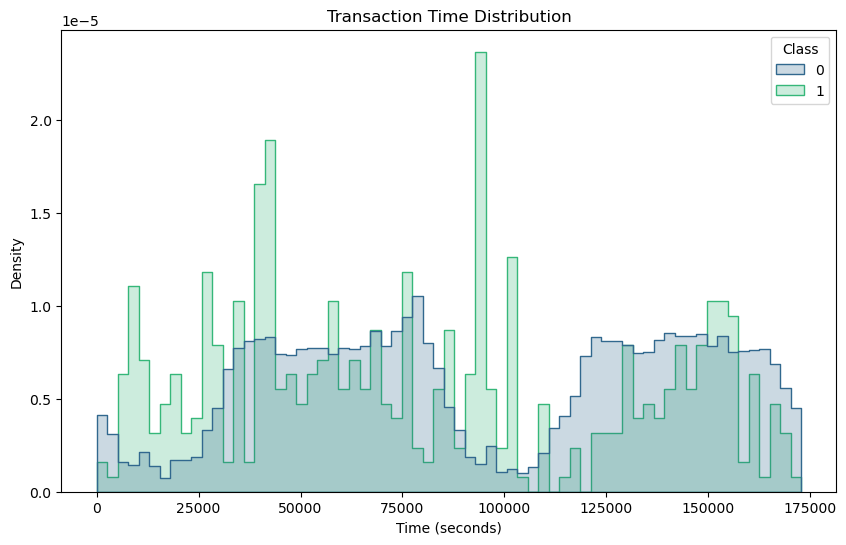

In [16]:
# Transactions over time
plt.figure(figsize=(10,6))
sns.histplot(df, x='Time', hue='Class', element='step', stat='density', common_norm=False, palette='viridis')
plt.title('Transaction Time Distribution')
plt.xlabel('Time (seconds)')
plt.ylabel('Density')

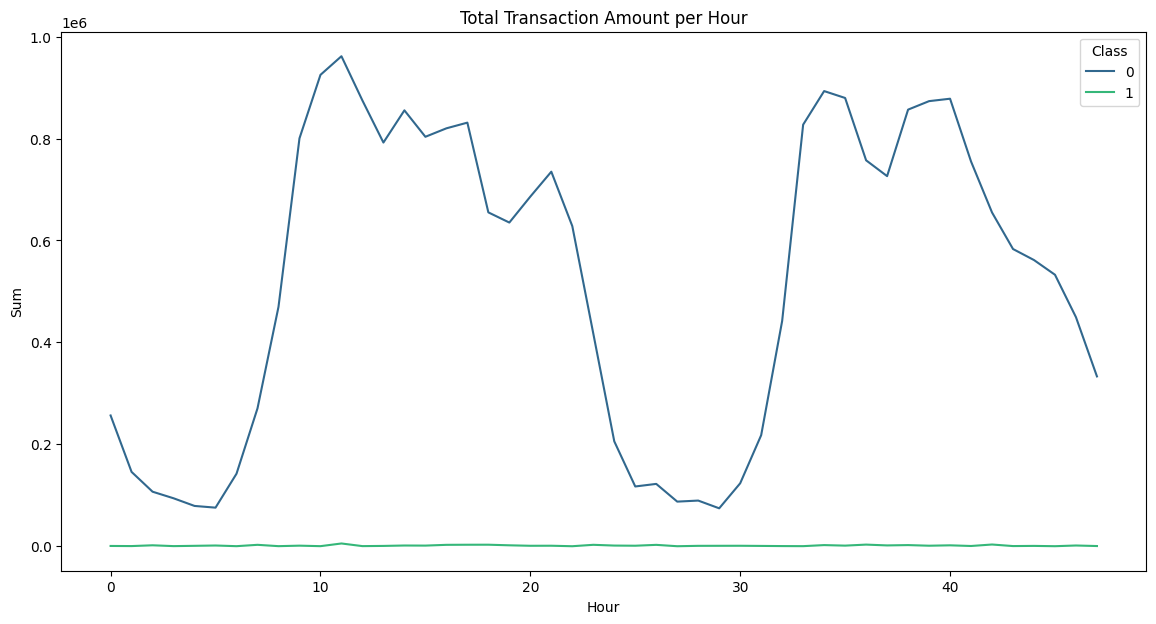

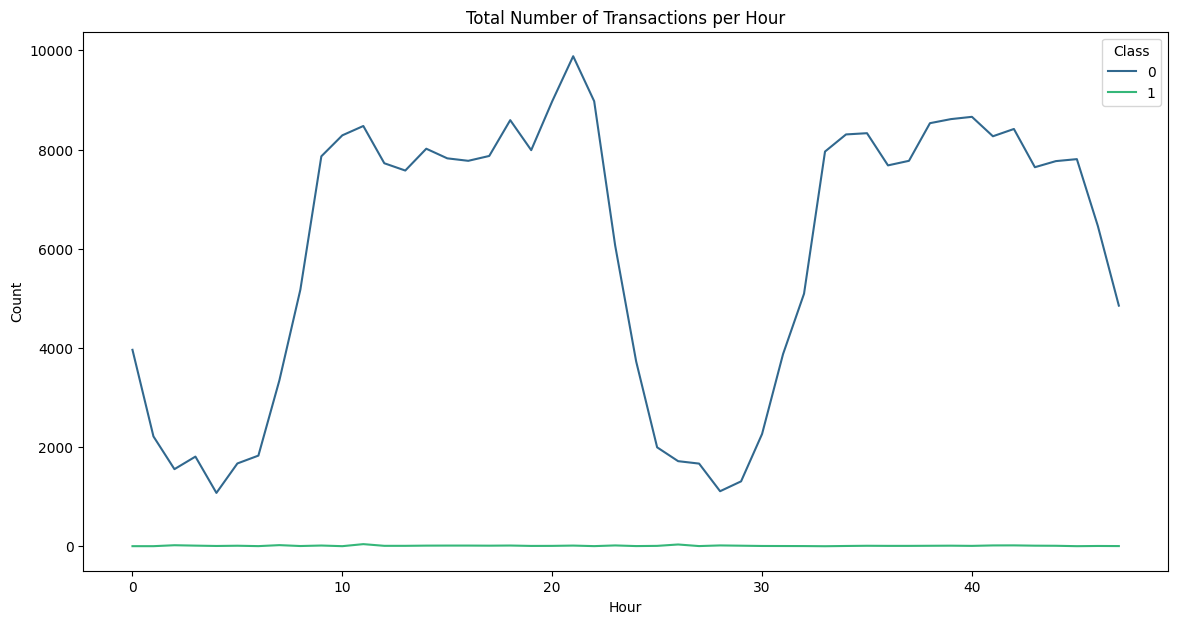

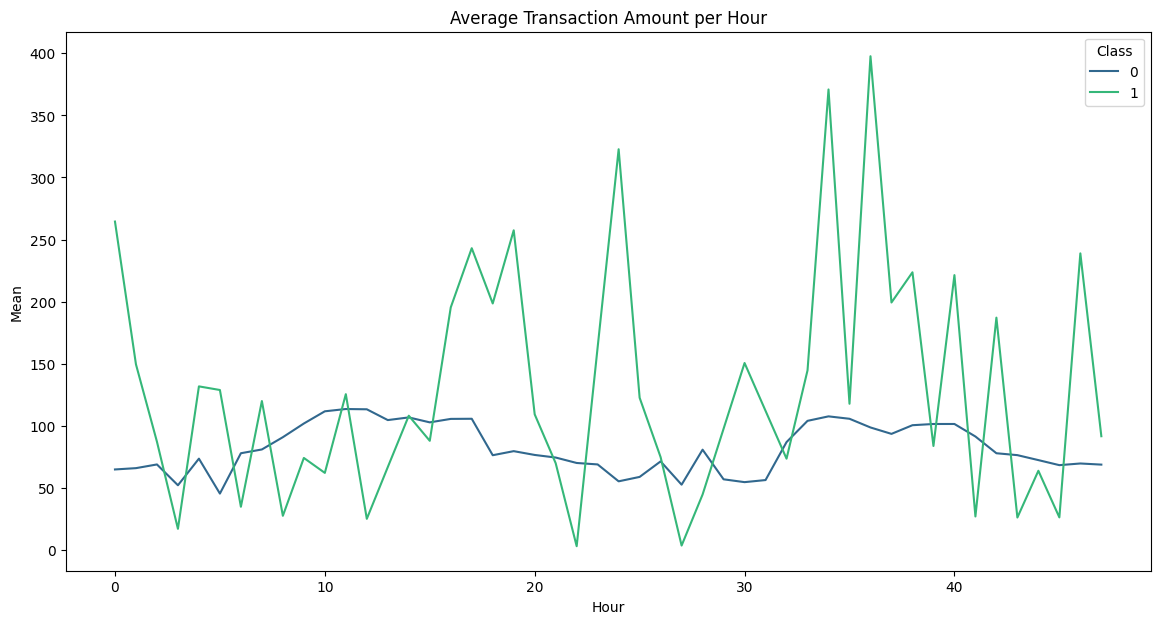

In [30]:
# Feature engineering - Create 'Hour' feature from 'Time'
# Convert 'Time' (in seconds) to hours by integer division with 3600.
df['Hour'] = (df['Time'] // 3600).astype(int)

# Aggregate transaction data by 'Hour' and 'Class'
# Group by 'Hour' and 'Class' to calculate various statistics for 'Amount': min, max, count, sum, mean, median, var
# Use reset_index() to "flatten" the DataFrame.. i.e convert the multi-level index back into regular columns
hourly_agg = df.groupby(['Hour', 'Class'])['Amount'].agg(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()

# Define a function to plot aggregated metrics
# Parameters:
# - 'metric': Metric to plot (e.g., 'sum', 'count', 'mean')
# - 'title': Plot title
def plot_hourly_agg(metric, title):
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=hourly_agg, x='Hour', y=metric, hue='Class', palette='viridis') #create a lineplot
    plt.title(title)
    plt.xlabel('Hour')
    plt.ylabel(metric.capitalize())
    plt.legend(title='Class')

# Plot different metrics
# Visualise how total amount, transaction count, and average amount change by hour for each class
plot_hourly_agg('sum', 'Total Transaction Amount per Hour')
plot_hourly_agg('count', 'Total Number of Transactions per Hour')
plot_hourly_agg('mean', 'Average Transaction Amount per Hour')


Text(0.5, 1.0, 'Feature Correlation Matrix')

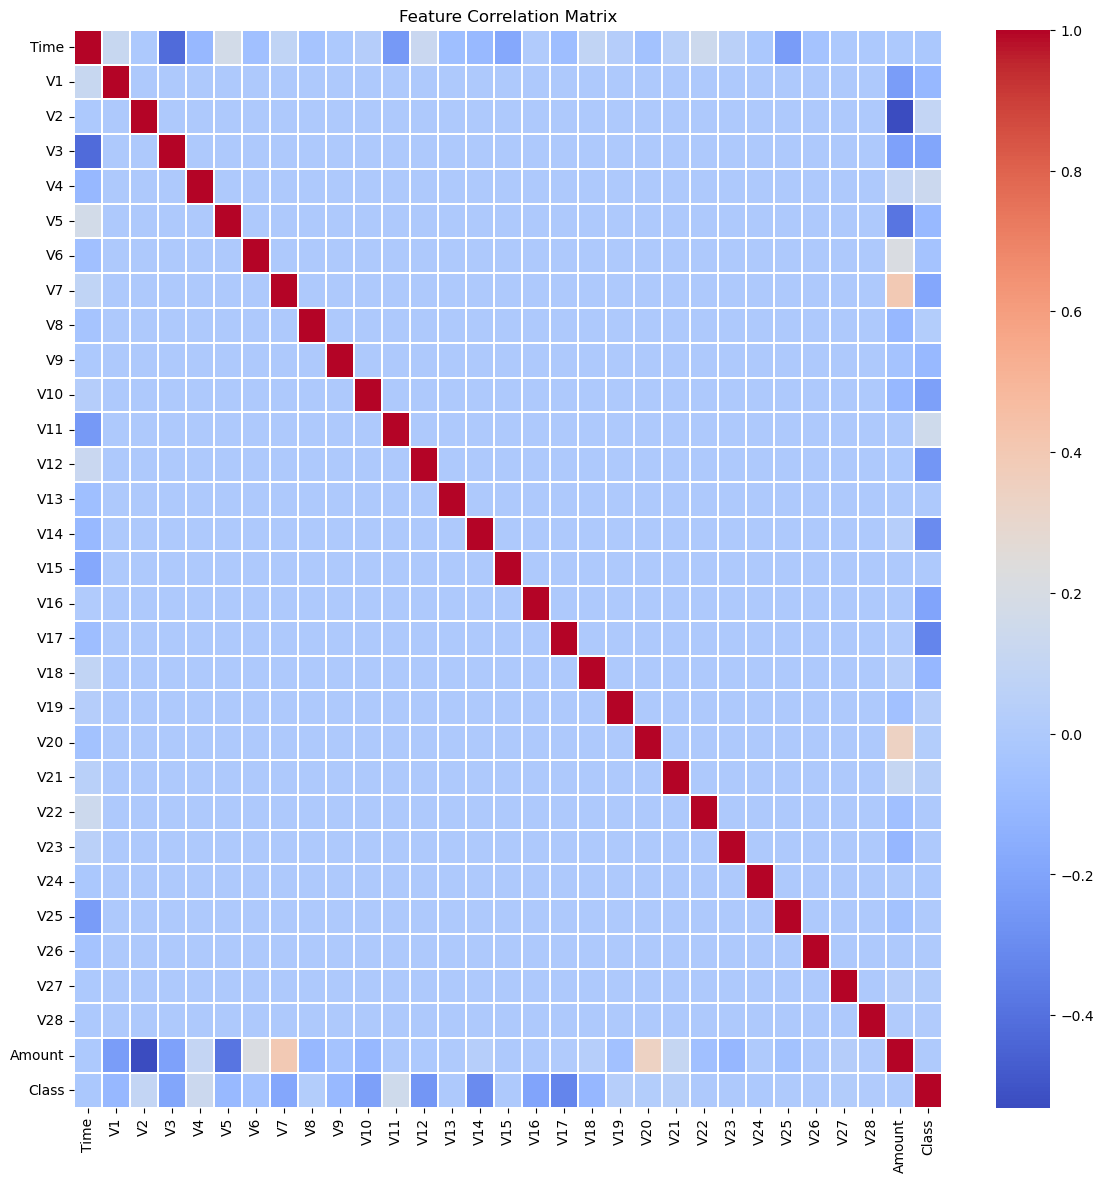

In [18]:
# Correlation matrix
plt.figure(figsize=(14,14))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.1)
plt.title('Feature Correlation Matrix')


In [ ]:
# Define predictor and target variables
X = df.drop(columns='Class')
y = df['Class']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialise RandomForestClassifier
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

## Results

# Confusion Matrix:
True Positives (TP): 69 (Correctly predicted as class 1)
True Negatives (TN): 56859 (Correctly predicted as class 0)
False Positives (FP): 3 (Incorrectly predicted as class 1 but actually class 0)
False Negatives (FN): 31 (Incorrectly predicted as class 0 but actually class 1)

# Classification Report
Class 0:
Precision: 1.00 (All predictions for class 0 are correct)
Recall: 1.00 (All actual class 0 instances are correctly identified)
F1-Score: 1.00 (Perfect balance of precision and recall)

Class 1:
Precision: 0.96 (96% of predicted class 1 instances are correct)
Recall: 0.69 (69% of actual class 1 instances are identified)
F1-Score: 0.80 (Harmonized mean of precision and recall for class 1)

# Accuracy Score
High Accuracy: The model performs exceptionally well overall with a very high accuracy score (99.94%).